In [1]:
import cudf
import cuspatial
import shapely
import pandas as pd
import numpy as np
import geopandas as gpd

## 1、读取费城违规停车数据

In [2]:
%%time
parking = pd.read_csv("/mnt/e/迅雷下载/Parking_Philadelphia/parking_violations.csv")

CPU times: user 11.4 s, sys: 966 ms, total: 12.4 s
Wall time: 16.1 s


In [3]:
parking.shape

(9412119, 13)

In [4]:
parking.head()

anon_ticket_number       issue_datetime state  anon_plate_id  division  \
0             1777797  2013-08-22 12:36:00    PA         878255       1.0   
1             1777798  2013-09-23 21:52:00    PA         878255       1.0   
2             1777799  2013-11-23 12:25:00    NJ         328900       1.0   
3             1777800  2013-01-18 22:56:00    NJ         244961       NaN   
4             1777801  2013-05-17 12:11:00    PA         665834       1.0   

              location      violation_desc  fine issuing_agency        lat  \
0        212 N 12TH ST  EXPIRED INSPECTION  41.0            PPA  39.956252   
1          900 RACE ST    METER EXPIRED CC  36.0            PPA  39.955233   
2  5448 GERMANTOWN AVE       METER EXPIRED  26.0            PPA  40.034175   
3         400 SPRINGGA    METER EXPIRED CC  36.0            PPA        NaN   
4      1000 FILBERT ST    METER EXPIRED CC  36.0            PPA  39.952661   

         lon    gps  zip_code  
0 -75.158937  False   19107.0  
1 -75.154730  False   19107.0  
2 -75.172386  False   19144.0  
3        NaN    NaN       NaN  
4 -75.157291  False   19107.0

## 2、过滤经纬度为空的数据

In [5]:
parking.dropna(subset=["lon", "lat"], inplace=True)
parking.shape

(8658916, 13)

## 3、cudf读取来自pandas中的数据

In [6]:
parking_cudf = cudf.from_pandas(parking)
parking_cudf.shape

(8658916, 13)

## 4、geopandas读取费城行政区数据进行预览

In [7]:
neighborhoods = gpd.read_file("/mnt/e/迅雷下载/Neighborhoods_Philadelphia/Neighborhoods_Philadelphia.shp")
neighborhoods.head()

NAME       LISTNAME        MAPNAME    Shape_Leng  Shape_Le_1  \
0     BRIDESBURG     Bridesburg     Bridesburg  27814.546521    0.087709   
1      BUSTLETON      Bustleton      Bustleton  48868.458365    0.153553   
2     CEDARBROOK     Cedarbrook     Cedarbrook  20021.415802    0.063660   
3  CHESTNUT_HILL  Chestnut Hill  Chestnut Hill  56394.297195    0.178849   
4     EAST_FALLS     East Falls     East Falls  27400.776417    0.089091   

   Shape_Area                                           geometry  
0    0.000437  POLYGON ((-75.06773 40.00541, -75.06765 40.005...  
1    0.001119  POLYGON ((-75.01560 40.09488, -75.01769 40.092...  
2    0.000244  POLYGON ((-75.18848 40.07274, -75.18846 40.072...  
3    0.000781  POLYGON ((-75.21221 40.08604, -75.21211 40.086...  
4    0.000398  POLYGON ((-75.18479 40.02838, -75.18427 40.027...

<AxesSubplot:>

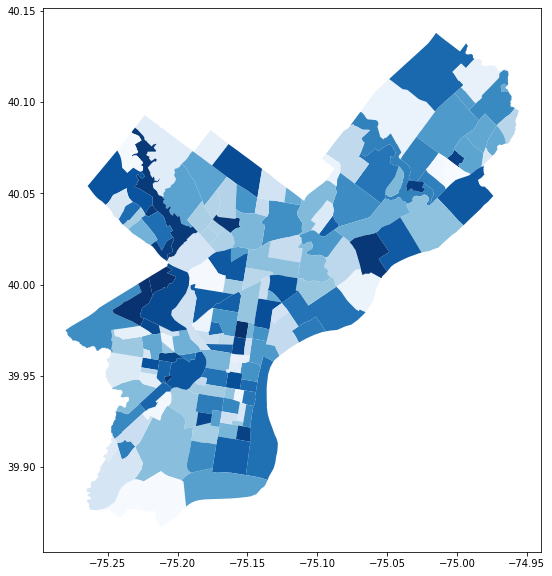

In [8]:
neighborhoods.plot("NAME", cmap="Blues", figsize=(10, 10))

In [9]:
neighborhoods.shape

(158, 7)

In [10]:
neighborhoods.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

## 5、利用GPU读取费城行政区划数据

In [11]:
neighborhoods_cuspatial = cuspatial.read_polygon_shapefile("/mnt/e/迅雷下载/Neighborhoods_Philadelphia/Neighborhoods_Philadelphia.shp")

In [12]:
neighborhoods_cuspatial

(0        0
 1        1
 2        2
 3        3
 4        4
       ... 
 153    153
 154    154
 155    155
 156    156
 157    157
 Name: f_pos, Length: 158, dtype: int32,
 0          0
 1        280
 2        390
 3        472
 4        711
        ...  
 153    14579
 154    14617
 155    14633
 156    14650
 157    14674
 Name: r_pos, Length: 158, dtype: int32,
                x          y
 0     -75.067733  40.005410
 1     -75.068340  40.006933
 2     -75.068547  40.007332
 3     -75.068870  40.008560
 4     -75.068878  40.008589
 ...          ...        ...
 14691 -75.160758  39.925707
 14692 -75.159187  39.925496
 14693 -75.157677  39.925281
 14694 -75.157119  39.927762
 14695 -75.156845  39.928979
 
 [14696 rows x 2 columns])

cuspatial读取polygon返回的数据结构：

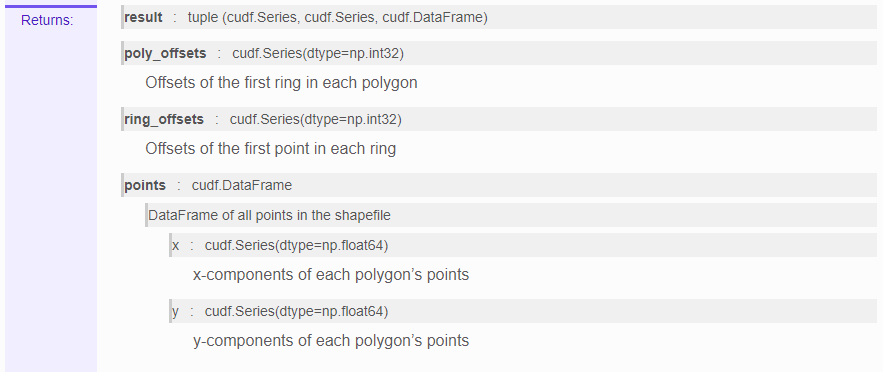

In [13]:
neighborhoods_cuspatial[0]

0        0
1        1
2        2
3        3
4        4
      ... 
153    153
154    154
155    155
156    156
157    157
Name: f_pos, Length: 158, dtype: int32

In [14]:
neighborhoods_cuspatial[1]

0          0
1        280
2        390
3        472
4        711
       ...  
153    14579
154    14617
155    14633
156    14650
157    14674
Name: r_pos, Length: 158, dtype: int32

In [15]:
neighborhoods_cuspatial[2]

x          y
0     -75.067733  40.005410
1     -75.068340  40.006933
2     -75.068547  40.007332
3     -75.068870  40.008560
4     -75.068878  40.008589
...          ...        ...
14691 -75.160758  39.925707
14692 -75.159187  39.925496
14693 -75.157677  39.925281
14694 -75.157119  39.927762
14695 -75.156845  39.928979

[14696 rows x 2 columns]

## 6、创建迭代并分析

In [16]:
# 创建迭代
def create_iterations(start, end, batches):
    iterations = list(np.arange(start, end, batches))
    iterations.append(end)
    return iterations

In [17]:
# 每次迭代分析31个多边形
pip_iterations = create_iterations(0, 158, 31)
pip_iterations

[0, 31, 62, 93, 124, 155, 158]

In [18]:
def perform_pip(cuda_df, cuspatial_data, polygon_gdf_col, iter_batch):
    cuda_df['polygonID'] = " "
    cuda_df['polygonName'] = " "
    for i in range(len(iter_batch)-1):
        start = pip_iterations[i]
        end = pip_iterations[i+1]
        pip = cuspatial.point_in_polygon(cuda_df['lon'] , cuda_df['lat'], 
                                         cuspatial_data[0][start:end], 
                                         cuspatial_data[1], 
                                         cuspatial_data[2]['x'], 
                                         cuspatial_data[2]['y']
                                        )

        for i in pip.columns:
            cuda_df['polygonID'].loc[pip[i]] = i
            cuda_df['polygonName'].loc[pip[i]] = polygon_gdf_col[i]
    return cuda_df

In [19]:
%%time
sjoined_cudf = perform_pip(parking_cudf, neighborhoods_cuspatial, neighborhoods["NAME"], pip_iterations)

CPU times: user 30.9 s, sys: 36.1 s, total: 1min 7s
Wall time: 1min 9s


In [20]:
sjoined_cudf

anon_ticket_number       issue_datetime state  anon_plate_id  \
0                   1777797  2013-08-22 12:36:00    PA         878255   
1                   1777798  2013-09-23 21:52:00    PA         878255   
2                   1777799  2013-11-23 12:25:00    NJ         328900   
4                   1777801  2013-05-17 12:11:00    PA         665834   
5                   1777802  2013-10-15 12:10:00    PA         847624   
...                     ...                  ...   ...            ...   
9412113             9415763  2017-12-20 09:04:00    PA         503673   
9412114             9415764  2017-12-23 08:25:00    PA         914127   
9412115             9415765  2017-12-26 19:54:00    PA        1251642   
9412116             9415766  2017-12-20 09:41:00    PA         623934   
9412117             9415767  2017-12-27 10:30:00    PA        4884418   

        division               location      violation_desc   fine  \
0            1.0          212 N 12TH ST  EXPIRED INSPECTION   41.0   
1            1.0            900 RACE ST    METER EXPIRED CC   36.0   
2            1.0    5448 GERMANTOWN AVE       METER EXPIRED   26.0   
4            1.0        1000 FILBERT ST    METER EXPIRED CC   36.0   
5           <NA>     1400 CALLOWHILL ST    METER EXPIRED CC   36.0   
...          ...                    ...                 ...    ...   
9412113     <NA>          2900 N 5TH ST  EXPIRED INSPECTION   41.0   
9412114     <NA>  1800 SPRING GARDEN ST    METER EXPIRED CC   36.0   
9412115     <NA>           99 N 11TH ST  STOP PROHIBITED CC   76.0   
9412116     <NA>          800 SPRUCE ST   HP RESERVED SPACE  301.0   
9412117     <NA>          3400 TREVI CT  EXPIRED INSPECTION   41.0   

        issuing_agency        lat        lon    gps zip_code polygonID  \
0                  PPA  39.956252 -75.158937  False  19107.0        93   
1                  PPA  39.955233 -75.154730  False  19107.0        92   
2                  PPA  40.034175 -75.172386  False  19144.0        56   
4                  PPA  39.952661 -75.157291  False  19107.0        93   
5                  PPA  39.959713 -75.162902  False  19130.0        98   
...                ...        ...        ...    ...      ...       ...   
9412113            PPA  39.995958 -75.139382   True  19133.0        75   
9412114            PPA  39.963310 -75.168218   True  19130.0        97   
9412115            PPA  39.952965 -75.157592   True     <NA>        93   
9412116            PPA  39.945860 -75.155208   True  19107.0        94   
9412117         POLICE  39.908856 -75.186630  False  19145.0       153   

                  polygonName  
0                 CENTER_CITY  
1                   CHINATOWN  
2        GERMANTOWN_PENN_KNOX  
4                 CENTER_CITY  
5                LOGAN_SQUARE  
...                       ...  
9412113              FAIRHILL  
9412114         SPRING_GARDEN  
9412115           CENTER_CITY  
9412116     WASHINGTON_SQUARE  
9412117           PACKER_PARK  

[8658916 rows x 15 columns]